In [1]:
import math
import csv
import time
from collections import Counter
from tqdm import tqdm
from typing import Optional, Tuple, Any, Union, Callable
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch import Tensor

import matplotlib.pyplot as plt
from collections import OrderedDict

from utils import *

加工済みの WMT16 (de->en) を読み込みます．
関数の詳細は utils.py を参照してください．
- WMT16 の加工は別プログラムで実行（気が向いたときに説明を記載します）

実行内容
- CSV ファイルからデータセットを読み込む
- トークナイズ
- ボキャブラリー統計
- データローダの作成
完了まで約５分くらかかります．

In [2]:
en_train_path = '../Datasets/custom_wmt16/train_en.csv'
de_train_path = '../Datasets/custom_wmt16/train_de.csv'

en_valid_path = '../Datasets/custom_wmt16/val_en.csv'
de_valid_path = '../Datasets/custom_wmt16/val_de.csv'

en_train_data = load_data(en_train_path)
de_train_data = load_data(de_train_path)

en_valid_data = load_data(en_valid_path)
de_valid_data = load_data(de_valid_path)

tokenizer_de = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')

vocab_de = build_vocab(de_train_data)
vocab_en = build_vocab(en_train_data)
vocab_de.set_default_index(vocab_de['<unk>'])
vocab_en.set_default_index(vocab_en['<unk>'])

train_data = data_process(
    texts_src=de_train_data, texts_tgt=en_train_data,
    vocab_src=vocab_de, vocab_tgt=vocab_en
)

valid_data = data_process(
    texts_src=de_valid_data, texts_tgt=en_valid_data,
    vocab_src=vocab_de, vocab_tgt=vocab_en
)

batch_size = 16
PAD_IDX = vocab_de['<pad>']
START_IDX = vocab_de['<start>']
END_IDX = vocab_de['<end>']

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=batch_generator)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=batch_generator)

4165231it [00:34, 119540.13it/s]
4165113it [00:36, 113568.55it/s]
2169it [00:00, 291360.66it/s]
2169it [00:00, 270588.19it/s]
100%|██████████| 4165231/4165231 [00:19<00:00, 210675.15it/s]
4165113it [04:13, 16411.99it/s]
2169it [00:00, 20221.31it/s]


0 または 1 を出力する BinaryGate クラス
- Encoder と Decoder それぞれに組み込まれています

In [3]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0, beta: float=0.667, gamma: float=-0.1, zeta: float=1.0,
                 hard: bool=True, *, name: Optional[str]=None, device=None, dtype=None
                ):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
    
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates, **factory_kwargs).fill_(init))
        #self.noise = torch.zeros(num_gates, **factory_kwargs)
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5) -> Tuple[Tensor, Tensor, Tuple[Tensor, int]]:
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

Pytorch 公式の multi_head_attention_forward を改造してあります

In [4]:
def multi_head_attention_forward(query: Tensor, key: Tensor, value: Tensor,
                                 embed_dim_to_check: int, num_heads: int,
                                 in_proj_weight: Optional[Tensor], in_proj_bias: Optional[Tensor],
                                 bias_k: Optional[Tensor], bias_v: Optional[Tensor],
                                 add_zero_attn: bool, dropout_p: float,
                                 out_proj_weight: Tensor, out_proj_bias: Optional[Tensor],
                                 training: bool=True, key_padding_mask: Optional[Tensor]=None,
                                 need_weights: bool=True, attn_mask: Optional[Tensor]=None,
                                 use_separate_proj_weight: bool=False,
                                 q_proj_weight: Optional[Tensor]=None, k_proj_weight: Optional[Tensor]=None, 
                                 v_proj_weight: Optional[Tensor]=None,
                                 static_k: Optional[Tensor]=None, static_v: Optional[Tensor]=None,
                                 average_attn_weights: bool=True,
                                 gate: Optional[Tensor]=None,
                                ) -> Tuple[Tensor, Optional[Tensor]]:
    
    tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v, out_proj_weight, out_proj_bias)
    if F.has_torch_function(tens_ops):
        return F.handle_torch_function(multi_head_attention_forward,
                                       tens_ops, query, key, value,
                                       embed_dim_to_check, num_heads, in_proj_weight, in_proj_bias,
                                       bias_k, bias_v, add_zero_attn, dropout_p,
                                       out_proj_weight, out_proj_bias, training=training,
                                       key_padding_mask=key_padding_mask, need_weights=need_weights,
                                       attn_mask=attn_mask, use_separate_proj_weight=use_separate_proj_weight,
                                       q_proj_weight=q_proj_weight, k_proj_weight=k_proj_weight, v_proj_weight=v_proj_weight,
                                       static_k=static_k, static_v=static_v,
                                       average_attn_weights=average_attn_weights,
                                      )
    is_batched = F._mha_shape_check(query, key,value, key_padding_mask, attn_mask, num_heads)
    
    tgt_len, bsz, embed_dim = query.shape
    src_len, _, _ = key.shape
    
    if isinstance(embed_dim, Tensor):
        head_dim = embed_dim.div(num_heads, rounding_mode='trunc')
    else:
        head_dim = embed_dim // num_heads
    
    if not use_separate_proj_weight:
        q, k, v = F._in_projection_packed(query, key, value, in_proj_weight, in_proj_bias)
    else:
        if in_proj_bias is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = in_proj_bias.chunk(3)
        q, k, v = F._in_projection(query, key, value, q_proj_weight, k_proj_weight, v_proj_weight, b_q, b_k, b_v)
    
    if attn_mask is not None:
        if attn_mask.dtype == torch.uint8:
            attn_mask = attn_mask.to(torch.bool)
    
        if attn_mask.dim() == 2:
            correct_2d_size = (tgt_len, src_len)
            attn_mask = attn_mask.unsqueeze(0)
        elif attn_mask.dim() == 3:
            correct_3d_size = (bsz * num_heads, tgt_len, src_len)
        
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        key_padding_mask = key_padding_mask.to(torch.bool)
    
    if bias_k is not None and bias_v is not None:
        k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
        v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
        
        if attn_mask is not None:
            attn_mask = F.pad(attn_maskn_mask, (0, 1))
        if key_padding_maske is not None:
            key_padding_mask = F.pad(key_padding_mask, (0, 1))
    
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if static_k is None:
        k = k.contiguous().view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        k = static_k
    
    if static_v is None:
        v = v.contiguous().view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        v = static_v
    
    if add_zero_attn:
        zero_attn_shape = (bsz * num_heads, 1, head_dim)
        k = torch.cat([k, torch.zeros(zero_attn_shape, dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros(zero_attn_shape, dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = F.pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = F.pad(key_padding_mask, (0, 1))
    
    src_len = k.size(1)
    
    if key_padding_mask is not None:
        key_padding_mask = key_padding_mask.view(bsz, 1, 1, src_len).expand(-1, num_heads, -1, -1).reshape(bsz * num_heads, 1, src_len)
    if attn_mask is None:
        attn_mask = key_padding_mask
    elif attn_mask.dtype == torch.bool:
        attn_mask = attn_mask.logical_or(key_padding_mask)
    else:
        attn_mask = attn_mask.masked_fill(key_padding_mask, float('-inf'))
    
    if attn_mask is not None and attn_mask.dtype == torch.bool:
        new_attn_mask = torch.zeros_like(attn_mask, dtype=q.dtype)
        new_attn_mask.masked_fill_(attn_mask, float('-inf'))
        attn_mask = new_attn_mask
        
    if not training:
        dropout_p = 0.0
    
    attn_output, attn_output_weights = F._scaled_dot_product_attention(q, k, v, attn_mask, dropout_p)
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len * bsz, embed_dim)
    
    if gate is not None:
        attn_output = attn_output * gate
    
    attn_output = F.linear(attn_output, out_proj_weight, out_proj_bias)
    attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))
    
    if need_weights:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        if average_attn_weights:
            attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
        
        if not is_batched:
            attn_output = attn_output.squeeze(1)
            attn_output_weights = attn_output_weights.squeeze(0)
        return attn_output, attn_output_weights
    else:
        if not is_batched:
            attn_output = attn_output.squeeze(1)
        return attn_output, None

multi_head_attention_forward を適用した MultiheadAttention クラス
- forward で引数に Gate の出力値を受け取ります

In [5]:
class MultiheadAttention(nn.Module):
    __constants__ = ['batch_first']
    bias_k: Optional[Tensor]
    bias_v: Optional[Tensor]
        
    def __init__(self, 
                 embed_dim: int=512, num_heads: int=8,
                 dropout: float=0.0, bias: bool=True, add_bias_kv: bool=False, add_zero_attn: bool=False,
                 kdim=None, vdim=None, batch_first: bool=False, device=None, dtype=None
                ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(MultiheadAttention, self).__init__()
        
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim
        
        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        
        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = nn.parameter.Parameter(torch.empty((embed_dim, embed_dim), **factory_kwargs))
            self.k_proj_weight = nn.parameter.Parameter(torch.empty((embed_dim, self.kdim), **factory_kwargs))
            self.v_proj_weight = nn.parameter.Parameter(torch.empty((embed_dim, self.vdim), **factory_kwargs))
            self.register_parameter('in_proj_weight', None)
            self.in_proj_weight = nn.parameter.Parameter(torch.empty((3 * embed_dim, embed_dim), **factory_kwargs))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)
        else:
            self.in_proj_weight = nn.parameter.Parameter(torch.empty((3 * embed_dim, embed_dim)))
        
        if bias:
            self.in_proj_bias = nn.parameter.Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = nn.modules.linear.NonDynamicallyQuantizableLinear(embed_dim, embed_dim, bias=bias, **factory_kwargs)
        
        if add_bias_kv:
            self.bias_k = nn.parameter.Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = nn.parameter.Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None
        
        self.add_zero_attn = add_zero_attn
        self._reset_parameters()
    
    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            nn.init.xavier_uniform_(self.in_proj_weight)
        else:
            nn.init.xavier_uniform_(self.q_proj_weight)
            nn.init.xavier_uniform_(self.k_proj_weight)
            nn.init.xavier_uniform_(self.v_proj_weight)
        
        if self.in_proj_bias is not None:
            nn.init.constant_(self.in_proj_bias, 0.0)
            nn.init.constant_(self.out_proj.bias, 0.0)
        
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)
            
    def __setstate__(self, state):
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True
        
        super(MultiheadAttention, self).__setstate__(state)
    
    def forward(self, query: Tensor, key: Tensor, value: Tensor, 
                key_padding_mask: Optional[Tensor]=None, need_weights: bool=True, attn_mask: Optional[Tensor]=None,
                average_attn_weights: bool=True, gate: Optional[Tensor] = None
               ) -> Tuple[Tensor, Optional[Tensor]]:
        
        if gate is not None:
            gate_ = torch.cat([gate[i].repeat(self.head_dim) for i in range(len(gate))])
        
        is_batched = query.dim() == 3
        if self.batch_first and is_batched:
            query, key, value = [x.transpose(1, 0) for x in (query, key, value)]
        
        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = multi_head_attention_forward(query, key, value,
                                                                            self.embed_dim, self.num_heads,
                                                                            self.in_proj_weight, self.in_proj_bias,
                                                                            self.bias_k, self.bias_v, self.add_zero_attn,
                                                                            self.dropout, self.out_proj.weight, self.out_proj.bias,
                                                                            training=training,
                                                                            key_padding_mask=key_padding_mask, need_weights=need_weights,
                                                                            attn_mask=attn_mask, use_separate_proj_weight=True,
                                                                            q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                                                                            v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights,
                                                                            gate=gate_
                                                                           )
        else:
            attn_output, attn_output_weights = multi_head_attention_forward(query, key, value,
                                                                            self.embed_dim, self.num_heads,
                                                                            self.in_proj_weight, self.in_proj_bias,
                                                                            self.bias_k, self.bias_v, self.add_zero_attn,
                                                                            self.dropout, self.out_proj.weight, self.out_proj.bias,
                                                                            training=self.training,
                                                                            key_padding_mask=key_padding_mask, need_weights=need_weights,
                                                                            attn_mask=attn_mask, average_attn_weights=average_attn_weights,
                                                                            gate=gate_
                                                                           )
        
        if self.batch_first and is_batched:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights

Encoder と Decoder の各層のクラス

In [6]:
class TransformerEncoderLayer(nn.Module):
    __constants__ = ['batch_first', 'norm_first']
    
    def __init__(self, d_model: int=512, nhead: int=8, dim_feedforward: int=2048,
                 dropout: float=0.1, activation: Union[str, Callable[[Tensor], Tensor]]=F.relu,
                 layer_norm_eps: float=1e-5, batch_first: bool=False, norm_first: bool=False,
                 device=None, dtype=None
                ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        
        super(TransformerEncoderLayer, self).__init__()
        
        self.self_attn_maps = []
        
        self.self_attn = MultiheadAttention(embed_dim=d_model, num_heads=nhead, 
                                            dropout=dropout, batch_first=batch_first, **factory_kwargs)
        self.gate = BinaryGate(nhead, init=2.0, **factory_kwargs)
        
        self.linear1 = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, **factory_kwargs)
        
        self.norm_first = norm_first
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        if isinstance(activation, str):
            self.activation = nn.modules.transformer._get_activation_fn(activation)
        else:
            self.activation = activation
            
    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayer, self).__setstate__(state)
    
    def forward(self, src: Tensor, src_mask: Optional[Tensor]=None, 
                src_key_padding_mask: Optional[Tensor]=None):
        self.self_attn_maps = []
        x = src
        if self.norm_first:
            x_, l0, sparsity = self._sa_block(self.norm1(x), src_mask, src_key_padding_mask)
            x = x + self._ff_block(self.norm2(x + x_))
        else:
            x_, l0, sparsity = self._sa_block(x, src_mask, src_key_padding_mask)
            x = self.norm1(x + x_)
            x = self.norm2(x + self._ff_block(x))
        
        return x, l0, sparsity
    
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]
                 ):
        
        gate, l0, sparsity = self.gate()
        x, w = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True,
                           average_attn_weights=False, gate=gate
                          )
        self.self_attn_maps.append(w)
        
        return self.dropout1(x), l0, sparsity
    
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)

In [7]:
class TransformerDecoderLayer(nn.Module):
    __constants__ = ['batch_first', 'norm_first']
    
    def __init__(self, d_model:int=512, nhead: int=8, 
                 dim_feedforward: int=2048, dropout: float=0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]]=F.relu,
                 layer_norm_eps: float=1e-5, batch_first: bool=False, norm_first: bool=False,
                 device=None, dtype=None
                ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerDecoderLayer, self).__init__()
        
        self.gate1 = BinaryGate(nhead, init=2.0, **factory_kwargs)
        self.gate2 = BinaryGate(nhead, init=2.0, **factory_kwargs)
        
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first, **factory_kwargs)
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first, **factory_kwargs)
        
        self.self_attn_maps = []
        self.multi_attn_maps = []
        
        self.linear1 = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, **factory_kwargs)
        
        self.norm_first = norm_first
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
        if isinstance(activation, str):
            self.activation = nn.modules.transformer._get_activation_fn(activation)
        else:
            self.activation = activation
        
    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerDecoderLayer, self).__setstate__(state)
    
    def forward(self, tgt: Tensor, memory: Tensor, 
                tgt_mask: Optional[Tensor]=None, memory_mask: Optional[Tensor]=None,
                tgt_key_padding_mask: Optional[Tensor]=None, memory_key_padding_mask: Optional[Tensor]=None
               ):
        
        self.self_attn_maps = []
        self.multi_attn_maps = []
        
        x = tgt
        if self.norm_first:
            x_, l0, sparsity = self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask)
            x = x + x_
            x_, l0_, sparsity_ = self._mha_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask)
            x = x + x_
            x = x + self._ff_block(self.norm3(x))
        else:
            x_, l0, sparsity = self._sa_block(x, tgt_mask, tgt_key_padding_mask)
            x = self.norm1(x + x_)
            
            x_, l0_, sparsity_ = self._mha_block(x, memory, memory_mask, memory_key_padding_mask)
            x = self.norm2(x + x_)
            x = self.norm3(x + self._ff_block(x))
            
        return x, l0+l0_, (sparsity, sparsity_)
            
        
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]
                 ) -> Tensor:
        
        gate, l0, sparsity = self.gate1()
        x, w = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           average_attn_weights=False,
                           gate=gate
                          )
        self.self_attn_maps.append(w)
        return self.dropout1(x), l0, sparsity
    
    def _mha_block(self, x: Tensor, mem: Tensor,
                   attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]
                  ) -> Tensor:
        gate, l0, sparsity = self.gate2()
        x, w = self.multihead_attn(x, mem, mem, 
                                   attn_mask=attn_mask, 
                                   key_padding_mask=key_padding_mask,
                                   average_attn_weights=False,
                                   gate=gate
                                  )
        self.multi_attn_maps.append(w)
        return self.dropout2(x), l0, sparsity
    
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)

上で宣言したクラスを積層するためのクラス

In [8]:
class TransformerEncoder(nn.Module):
    __constants__ = ['norm']
    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.modules.transformer._get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        
    def forward(self, src: Tensor, mask: Optional[Tensor]=None, src_key_padding_mask: Optional[Tensor]=None):
        output = src
        l0_loss = 0.0
        sparsity = []
        
        for mod in self.layers:
            output, l0, s = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
            l0_loss = l0_loss + l0
            sparsity.append(s)
        
        if self.norm is not None:
            output = self.norm(output)
        
        return output, l0_loss, sparsity

class TransformerDecoder(nn.Module):
    __constants__ = ['norm']
    
    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        self.layers = nn.modules.transformer._get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
    
    def forward(self, tgt: Tensor, memory: Tensor, 
                tgt_mask: Optional[Tensor]=None,
                memory_mask: Optional[Tensor]=None, tgt_key_padding_mask: Optional[Tensor]=None,
                memory_key_padding_mask: Optional[Tensor]=None
               ):
        
        output = tgt
        l0_loss = 0.0
        sparsity = []
        
        for mod in self.layers:
            output, l0, s = mod(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)
            l0_loss = l0_loss + l0
            sparsity.append(s)
        
        if self.norm is not None:
            output = self.norm(output)
        
        return output, l0_loss, sparsity

In [9]:
class Encoder(nn.Module): 
    def __init__(self, vocab_size_src: int, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 custom_encoder: Optional[Any] = None,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Encoder, self).__init__()
        
        self.token_embedding_src = TokenEmbedding(vocab_size_src, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        if custom_encoder is not None:
            self.encoder = custom_encoder
        else:
            encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,
                                                    activation, layer_norm_eps, batch_first, norm_first,
                                                    **factory_kwargs)
        encoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        self._reset_parameters()
        
        self.d_model = d_model
        self.nhead = nhead

        self.batch_first = batch_first
    
    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor]=None):
        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        memory, l0, sparsity = self.encoder(embedding_src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        return memory, l0, sparsity
        
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
class Decoder(nn.Module):
    def __init__(self, vocab_size_tgt: int, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 custom_decoder: Optional[Any] = None,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Decoder, self).__init__()
        
        self.token_embedding_tgt = TokenEmbedding(vocab_size_tgt, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        if custom_decoder is not None:
            self.decoder = custom_decoder
        else:
            decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout,
                                                    activation, layer_norm_eps, batch_first, norm_first,
                                                    **factory_kwargs)
            
        decoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

        self.batch_first = batch_first
    
    def forward(self, memory: Tensor, tgt: Tensor, tgt_mask: Optional[Tensor]=None,
                memory_mask: Optional[Tensor]=None,
                tgt_key_padding_mask: Optional[Tensor]=None, memory_key_padding_mask: Optional[Tensor]=None):
        
        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        output, l0, sparsity = self.decoder(embedding_tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        
        return output, l0, sparsity
    
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

Decoder の最終層の出力を受け取る Linear 層

In [10]:
class Transformer_Linear(nn.Module):
    def __init__(self, embedding_size, vocab_size_tgt):
        super(Transformer_Linear, self).__init__()
        self.output = nn.Linear(embedding_size, vocab_size_tgt)
        
    def forward(self, outs):
        return self.output(outs)

embedding_size は各単語の次元数
- Transformer の次元数と同じ値

vocab_size_src
- 翻訳される前の文章の言語の単語数
vocab_size_tgt
- 翻訳された後の文章の言語の単語数

In [11]:
embedding_size = 512

vocab_size_src = len(vocab_de)
vocab_size_tgt = len(vocab_en)

print('src vocab size: ', vocab_size_src)
print('tgt vocab size: ', vocab_size_tgt)

src vocab size:  1817025
tgt vocab size:  769754


now_lambda
- 正弦波の 0 ~ $\frac{\pi}{2}$ で徐々に値を増加 

In [12]:
def now_lambda(i, max_iter=10000, max_lambda=0.5):
    i_ = i if i <= max_iter else max_iter
    return max_lambda * math.sin(math.pi*i_/(max_iter*2))

学習用の関数
- $\lambda$ の値を変更することで調整

In [13]:
def train(enc, dec, fc, save_path, _lambda=None, max_iter=10000, interval=10, enc_device=0, dec_device=1, fc_device=2):

    
    val_loss_list = []
    best_loss = float('inf')
    loss_list = []
    
    enc_gate = []
    dec_gate = []

    with tqdm(train_loader) as pbar:
        for i, (src, tgt) in enumerate(pbar):
            if i == max_iter:
                break
        
            if _lambda == None:
                lambda_ = now_lambda(i)
            else:
                lambda_ = _lambda
        
            enc.train()
            dec.train()
            fc.train()
    
            input_tgt = tgt[:-1, :]
            mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)
        
            src = src.cuda(enc_device)
            mask_src = mask_src.cuda(enc_device)
            padding_mask_src = padding_mask_src.cuda(enc_device)
            memory, L0_loss_enc, enc_sparsity = enc(src, mask_src, padding_mask_src)
            enc_gate.append(enc_sparsity)
    
            memory = memory.cuda(dec_device)
            mask_tgt = mask_tgt.cuda(dec_device)
            padding_mask_tgt = padding_mask_tgt.cuda(dec_device)
            padding_mask_src = padding_mask_src.cuda(dec_device)
            input_tgt = tgt[:-1, :].cuda(dec_device)
            outs, L0_loss_dec, dec_sparsity = dec(memory, input_tgt, tgt_mask=mask_tgt, 
                                                  tgt_key_padding_mask=padding_mask_tgt, 
                                                  memory_key_padding_mask=padding_mask_src)
            dec_gate.append(dec_sparsity)
    
            outs = outs.cuda(fc_device)
            logits = fc(outs)
    
            optimizer.zero_grad()
            output_tgt_ = tgt[1:, :].cuda(fc_device)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt_.reshape(-1)) + lambda_ * (L0_loss_enc.cuda(fc_device) + L0_loss_dec.cuda(fc_device))
            loss.backward()
    
            optimizer.step()
            loss_list.append(loss.item())
    
            if i % interval == 0:
                enc.eval()
                dec.eval()
                fc.eval()
                v_loss = 0
                
                with torch.no_grad():
                    for src_, tgt_ in valid_loader:
                        input_tgt_ = tgt_[:-1, :]
                        mask_src_, mask_tgt_, padding_mask_src_, padding_mask_tgt_ = create_mask(src_, input_tgt_, PAD_IDX)
                        
                        src_ = src_.cuda(enc_device)
                        mask_src_ = mask_src_.cuda(enc_device)
                        padding_mask_src_ = padding_mask_src_.cuda(enc_device)
                        memory_, L0_loss_enc_, _ = enc(src_, mask_src_, padding_mask_src_)
            
                        memory_ = memory_.cuda(dec_device)
                        mask_tgt_ = mask_tgt_.cuda(dec_device)
                        padding_mask_tgt_ = padding_mask_tgt_.cuda(dec_device)
                        padding_mask_src_ = padding_mask_src_.cuda(dec_device)
                        input_tgt_ = tgt_[:-1, :].cuda(dec_device)
                        outs_, L0_loss_dec_, _ = dec(memory_, input_tgt_, tgt_mask=mask_tgt_, 
                                                     tgt_key_padding_mask=padding_mask_tgt_, 
                                                     memory_key_padding_mask=padding_mask_src_)
            
                        outs_ = outs_.cuda(fc_device)
                        logits_ = fc(outs_)
            
                        output_tgt_ = tgt_[1:, :].cuda(fc_device)
                        loss_ = criterion(logits_.reshape(-1, logits_.shape[-1]), output_tgt_.reshape(-1))
                        v_loss += loss_.item()
                
                    v_loss = v_loss / len(valid_loader)
                    val_loss_list.append(v_loss)
        
                    if best_loss > v_loss:
                        best_loss = v_loss
            
                        torch.save(enc.state_dict(), save_path+'_Enc.pth')
                        torch.save(dec.state_dict(), save_path+'_Dec.pth')
                        torch.save(fc.state_dict(), save_path+'_Fc.pth')
                
            pbar.set_postfix({"best_loss": best_loss, 'now_loss':v_loss})

    return loss_list, val_loss_list, enc_gate, dec_gate

学習結果をプロットします

In [26]:
def Plotter(train_loss, valid_loss, enc_gate, dec_gate):
    x1 = np.array([i for i in range(len(train_loss))])
    x2 = np.array([i for i in range(len(valid_loss))]) * 10.0
    
    plt.plot(x1, train_loss, label='Train', color='red')
    plt.plot(x2, valid_loss, label='Valid', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    enc_sparsity = []
    dec_sparsity1 = []
    dec_sparsity2 = []
    
    for i in range(len(enc_gate)):
        e = 0
        d1 = 0
        d2 = 0
        for layer in range(len(enc_gate[0])):
            e += (enc_gate[i][layer][1] - enc_gate[i][layer][0])/enc_gate[i][layer][1]
            d1 += (dec_gate[i][layer][0][1] - dec_gate[i][layer][0][0]) / dec_gate[i][layer][0][1]
            d2 += (dec_gate[i][layer][1][1] - dec_gate[i][layer][1][0]) / dec_gate[i][layer][1][1]
        enc_sparsity.append(e / 8)
        dec_sparsity1.append(d1 / 8)
        dec_sparsity2.append(d2 / 8)
        
    enc_sparsity = np.array(enc_sparsity)
    dec_sparsity1 = np.array(dec_sparsity1)
    dec_sparsity2 = np.array(dec_sparsity2)
    
    plt.plot(x1, enc_sparsity, label='enc-sa', color='red')
    plt.plot(x1, dec_sparsity1, label='dec-sa', color='blue')
    plt.plot(x1, dec_sparsity2, label='dec-mha', color='green')
    plt.xlabel('Iterations')
    plt.ylabel('Sparsity')
    plt.legend()
    plt.show()
    
    all_sparsity = enc_sparsity + dec_sparsity1 + dec_sparsity2
    all_sparsity /= 3.0
    plt.plot(x1, all_sparsity, color='red')
    plt.xlabel('Iterations')
    plt.ylabel('Sparsity')
    plt.show()

enc_device
- encoder を載せる GPU の指定
dec_device
- decoder を載せる GPU の指定
fc_device
- fc を載せる GPU の指定

In [14]:
enc_device = 0
dec_device = 1
fc_device = 2

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

最初だけ初期値を保存します
- ここ以降の学習では，保存した初期値を読み込みます

In [15]:
enc = Encoder(vocab_size_src, d_model=embedding_size).cuda(enc_device)
dec = Decoder(vocab_size_tgt, d_model=embedding_size).cuda(dec_device)
fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(fc_device)

torch.save(enc.state_dict(), '../Models/Enc_init.pth')
torch.save(dec.state_dict(), '../Models/Dec_init.pth')
torch.save(fc.state_dict(), '../Models/Fc_init.pth')

max_iter = 10000
interval = 10
optimizer = torch.optim.Adam([{'params': enc.parameters()},{'params': dec.parameters()},{'params': fc.parameters()}])

$\lambda=0.0$

In [16]:
train_loss, valid_loss, enc_gate, dec_gate = train(enc, dec, fc, '../Models/BaseLine', _lambda=0.0, 
                                                              max_iter=max_iter, interval=interval,
                                                              enc_device=enc_device, dec_device=dec_device, fc_device=fc_device
                                                             )

  4%|▍         | 10000/260320 [4:18:08<107:41:42,  1.55s/it, best_loss=7.58, now_loss=9.5] 


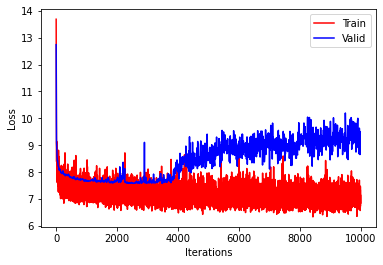

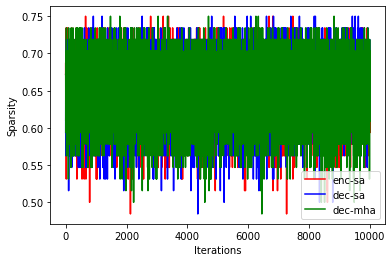

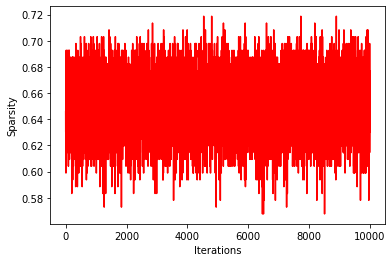

In [41]:
Plotter(train_loss, valid_loss, enc_gate, dec_gate)

In [42]:
enc = Encoder(vocab_size_src, d_model=embedding_size).cuda(enc_device)
dec = Decoder(vocab_size_tgt, d_model=embedding_size).cuda(dec_device)
fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(fc_device)

enc.load_state_dict(torch.load('../Models/Enc_init.pth'))
dec.load_state_dict(torch.load('../Models/Dec_init.pth'))
fc.load_state_dict(torch.load('../Models/Fc_init.pth'))

max_iter = 10000
interval = 10
optimizer = torch.optim.Adam([{'params': enc.parameters()},{'params': dec.parameters()},{'params': fc.parameters()}])

$\lambda=0.1$

In [43]:
train_loss, valid_loss, enc_gate, dec_gate = train(enc, dec, fc, '../Models/BaseLine.01', _lambda=0.1, 
                                                              max_iter=max_iter, interval=interval,
                                                              enc_device=enc_device, dec_device=dec_device, fc_device=fc_device
                                                             )

  4%|▍         | 10000/260320 [5:04:13<126:55:31,  1.83s/it, best_loss=7.48, now_loss=7.49]


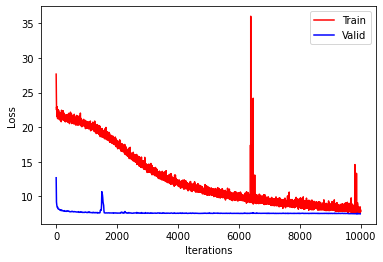

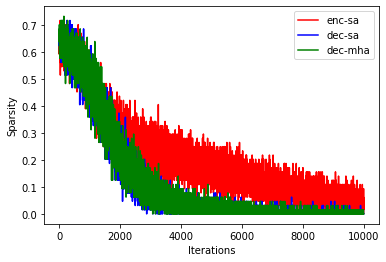

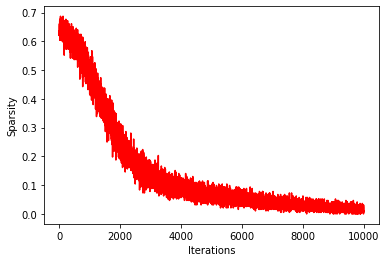

In [44]:
Plotter(train_loss, valid_loss, enc_gate, dec_gate)

初期値を読み込む

In [51]:
enc = Encoder(vocab_size_src, d_model=embedding_size).cuda(enc_device)
dec = Decoder(vocab_size_tgt, d_model=embedding_size).cuda(dec_device)
fc = Transformer_Linear(embedding_size, vocab_size_tgt).cuda(fc_device)

enc.load_state_dict(torch.load('../Models/Enc_init.pth'))
dec.load_state_dict(torch.load('../Models/Dec_init.pth'))
fc.load_state_dict(torch.load('../Models/Fc_init.pth'))

max_iter = 10000
interval = 10
optimizer = torch.optim.Adam([{'params': enc.parameters()},{'params': dec.parameters()},{'params': fc.parameters()}])

$\lambda=0.2$

In [52]:
train_loss, valid_loss, enc_gate, dec_gate = train(enc, dec, fc, '../Models/BaseLine.02', _lambda=0.2, 
                                                              max_iter=max_iter, interval=interval,
                                                              enc_device=enc_device, dec_device=dec_device, fc_device=fc_device
                                                             )

  4%|▍         | 10000/260320 [4:45:33<119:08:08,  1.71s/it, best_loss=7.43, now_loss=7.48]


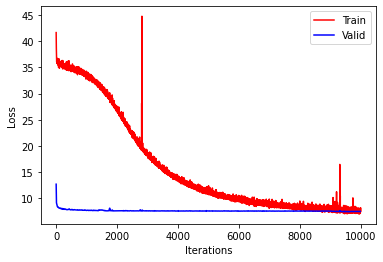

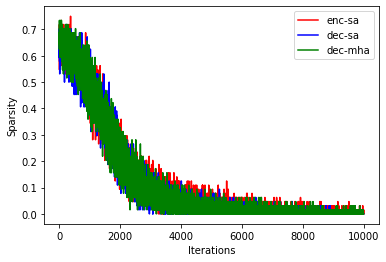

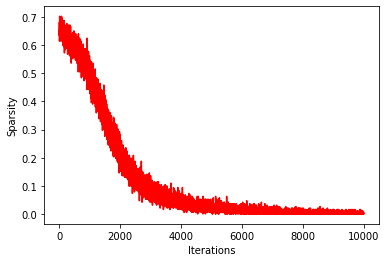

In [53]:
Plotter(train_loss, valid_loss, enc_gate, dec_gate)

初期値を読み込む

In [54]:
enc.load_state_dict(torch.load('../Models/Enc_init.pth'))
dec.load_state_dict(torch.load('../Models/Dec_init.pth'))
fc.load_state_dict(torch.load('../Models/Fc_init.pth'))

max_iter = 10000
interval = 10
optimizer = torch.optim.Adam([{'params': enc.parameters()},{'params': dec.parameters()},{'params': fc.parameters()}])

$\lambda=0.3$

In [55]:
train_loss, valid_loss, enc_gate, dec_gate = train(enc, dec, fc, '../Models/BaseLine.03', _lambda=0.3, 
                                                              max_iter=max_iter, interval=interval,
                                                              enc_device=enc_device, dec_device=dec_device, fc_device=fc_device
                                                             )

  4%|▍         | 10000/260320 [4:35:16<114:50:39,  1.65s/it, best_loss=7.44, now_loss=7.45]


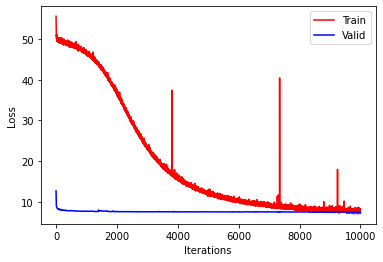

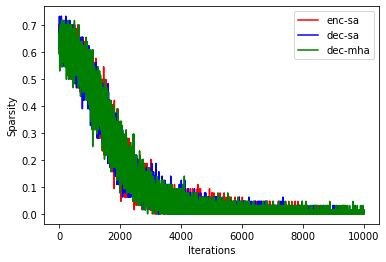

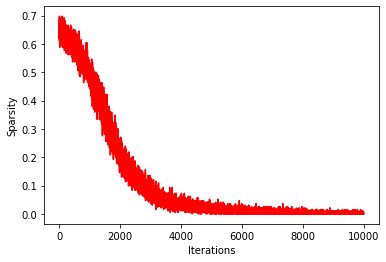

In [56]:
Plotter(train_loss, valid_loss, enc_gate, dec_gate)

初期値を読み込む

In [57]:
enc.load_state_dict(torch.load('../Models/Enc_init.pth'))
dec.load_state_dict(torch.load('../Models/Dec_init.pth'))
fc.load_state_dict(torch.load('../Models/Fc_init.pth'))

max_iter = 10000
interval = 10
optimizer = torch.optim.Adam([{'params': enc.parameters()},{'params': dec.parameters()},{'params': fc.parameters()}])

$\lambda$ 正弦波で増加

  4%|▍         | 10000/260320 [4:36:08<115:12:34,  1.66s/it, best_loss=7.45, now_loss=7.47]


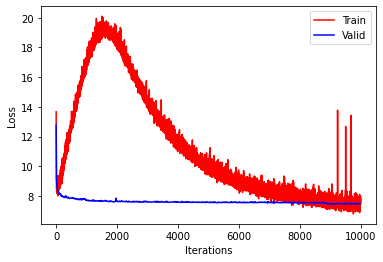

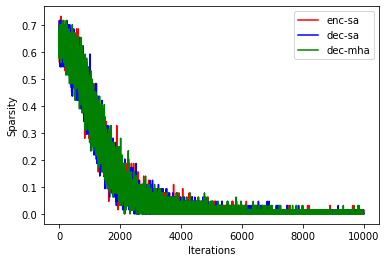

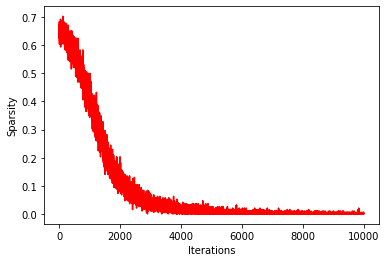

In [58]:
train_loss, valid_loss, enc_gate, dec_gate = train(enc, dec, fc, '../Models/BaseLine.sin10000', _lambda=None, 
                                                              max_iter=max_iter, interval=interval,
                                                              enc_device=enc_device, dec_device=dec_device, fc_device=fc_device
                                                             )

Plotter(train_loss, valid_loss, enc_gate, dec_gate)